In [51]:
#Import Librarires
import tensorflow 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, LocallyConnected2D, Dense,ReLU,Softmax,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Technically not necessary in newest versions of jupyter
import os
import cv2
import numpy as np
from matplotlib.pyplot import imread
from tensorflow.keras.preprocessing import image
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)

### Parent Folder where Data is stored

In [4]:
my_data_dir = "D:\\data science\\Myprojects\\DeepFace\\dataset\\people"

### Storing the filenames in a Pandas dataframe

In [5]:
path = my_data_dir
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'\\'+img)
        
print('Images: ',len(img_names))

Images:  9


In [6]:
img_names[1].split('\\')[-2]

'Elon Musk'

### Using Haar Cascades to localize the faces and store them as a new image

In [7]:
face_cascade = cv2.CascadeClassifier('D:/data science/CV/Computer-Vision-with-Python/DATA/haarcascades/haarcascade_frontalface_default.xml')
save_path="D:\\data science\\Myprojects\\DeepFace\\dataset\\faces\\"
i=1
for file in img_names:
    face_img=cv2.imread(file,0)
    face_rects = face_cascade.detectMultiScale(face_img) 
    for (x,y,w,h) in face_rects: 
                cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 1) 
                crop_img = face_img[y:y+h, x:x+w]
                if file.split('\\')[-2] in os.listdir(save_path):
                    cv2.imwrite(save_path + "\\" + str(file.split('\\')[-2]) + "\\"+str(i)+".jpg" , crop_img)
                else :
                    os.mkdir(save_path+"\\"+str(file.split('\\')[-2]))
                    cv2.imwrite(save_path+ "\\" +str(file.split('\\')[-2])+ "\\" +str(i)+".jpg" , crop_img)
                i=i+1
    

### Tensorflow Image Data Generator

In [8]:
image_gen = ImageDataGenerator(rescale=1/255.)

In [9]:
train_data = image_gen.flow_from_directory(directory="D:/data science/Myprojects/DeepFace/dataset/faces",batch_size=1,target_size=(152,152))

Found 10 images belonging to 2 classes.


### Initializing the Model

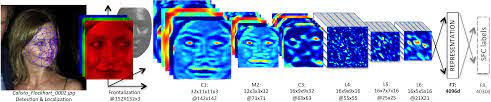

In [10]:
model = Sequential()
model.add(Conv2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
model.add(MaxPool2D(pool_size=3, strides=2, padding='same', name='M2'))
model.add(Conv2D(16, (9, 9), activation='relu', name='C3'))
model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model.add(Flatten(name='F0'))
model.add(Dense(4096, activation='relu', name='F7'))
model.add(Dropout(rate=0.5, name='D0'))
model.add(Dense(2, activation='softmax', name='F8')) 
## Do not use Sigmoid as we prefer mapping the probabilities

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
_________________________________________________________________
F0 (Flatten)                 (None, 7056)              0

### Training and Compiling the model

In [15]:
from tensorflow.keras.optimizers import SGD
model.compile(loss="categorical_crossentropy",optimizer=SGD(learning_rate=0.01))

In [16]:
history=model.fit(train_data,epochs=30)

Epoch 1/30
10/10 [==============================] - 3s 267ms/step - loss: 0.6957
Epoch 2/30
10/10 [==============================] - 3s 262ms/step - loss: 0.6958
Epoch 3/30
10/10 [==============================] - 3s 276ms/step - loss: 0.6954
Epoch 4/30
10/10 [==============================] - 3s 304ms/step - loss: 0.6957
Epoch 5/30
10/10 [==============================] - 3s 285ms/step - loss: 0.6961
Epoch 6/30
10/10 [==============================] - 3s 284ms/step - loss: 0.6965
Epoch 7/30
10/10 [==============================] - 3s 289ms/step - loss: 0.6968
Epoch 8/30
10/10 [==============================] - 3s 302ms/step - loss: 0.6962
Epoch 9/30
10/10 [==============================] - 3s 292ms/step - loss: 0.6950
Epoch 10/30
10/10 [==============================] - 3s 271ms/step - loss: 0.6959
Epoch 11/30
10/10 [==============================] - 3s 270ms/step - loss: 0.6957
Epoch 12/30
10/10 [==============================] - 3s 273ms/step - loss: 0.6958
Epoch 13/30
10/10 [======

In [19]:
model.save_weights("lwa2.h5")

In [21]:
# model.load_weights("lwa2.h5")

### Dropping the last 3 layers and keeping the model upto the Flatten layer in order to get the vector

In [22]:
deepface_model = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

### A function to extract faces from the test image and preprocess the same

In [54]:
def preprocess_image(face_img,i):
    face_cascade = cv2.CascadeClassifier('D:/data science/CV/Computer-Vision-with-Python/DATA/haarcascades/haarcascade_frontalface_default.xml')
    save_path="D:\\data science\\Myprojects\\DeepFace\\dataset\\faces\\"
    face_rects = face_cascade.detectMultiScale(face_img) 
    for (x,y,w,h) in face_rects: 
                cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 1) 
                crop_img = face_img[y:y+h, x:x+w]
                cv2.imwrite(save_path+"faceimg"+str(i)+".jpg",crop_img)
    img = imread(save_path+"faceimg"+str(i)+".jpg")
    image1 = tensorflow.image.resize(img,[152,152])
    img_arr = image.img_to_array(image1)
    img_arr = np.expand_dims((img_arr),axis=0)

    return img,img_arr

### Test Case: Elon Musk

In [40]:
face_image_test_1=imread("test/test1.jpg")
face_image_test_2= imread("test/test2.jpg")

### First Image

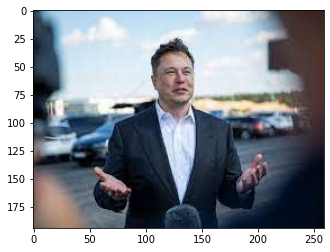

In [43]:
plt.imshow(face_image_test_1)

### Second Image

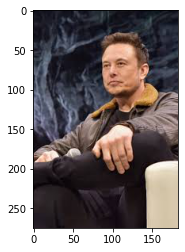

In [44]:
plt.imshow(face_image_test_2)


### Extracted Face from first image

In [55]:
img1,imgarr1 = preprocess_image(face_image_test_1,1)

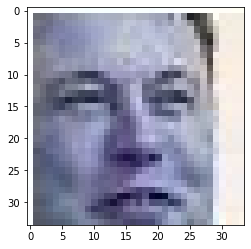

In [56]:
plt.imshow(img1)

### Extracted face from second image

In [57]:
img2,imgarr2 = preprocess_image(face_image_test_2,2)

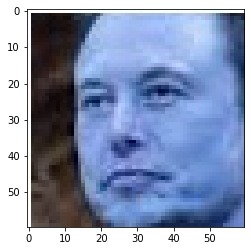

In [58]:
plt.imshow(img2)

### Forward Propagate the images

In [59]:
embedding_1 = deepface_model.predict(imgarr1)
embedding_2 = deepface_model.predict(imgarr2)

### Calculate the cosine similarity

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
def cosine_sim(emb1,emb2):
    print(cosine_similarity(emb1,emb2))

# 0.98 almost identical! (Elon Musk)

In [64]:
cosine_sim(embedding_1,embedding_2)

[[0.9815215]]


### Test Case 2 : Mark Zuckerberg

In [65]:
face_image_test3 = cv2.imread("test/test3.jpg")

In [71]:
face_image_test4 = cv2.imread("test/test4.jpg")

In [68]:
img3,imgarr3 = preprocess_image(face_image_test3,3)

In [72]:
img4,imgarr4 = preprocess_image(face_image_test4,4)

### First Image : Mark Zuckerberg

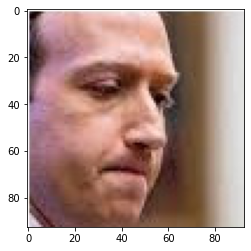

In [73]:
plt.imshow(img3)

### Second Image : Mark Zuckerberg

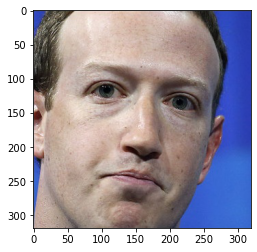

In [74]:
plt.imshow(img4)

### Forward Prop

In [75]:
embedding_3 = deepface_model.predict(imgarr3)
embedding_4 = deepface_model.predict(imgarr4)

### Calculate Cosine Similarity

In [76]:
cosine_sim(embedding_3,embedding_4)

[[0.9803134]]


## You can also use L2 norm and Euclidean Distance as measure of dissimilarity

In [82]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [85]:
findEuclideanDistance(l2_normalize(embedding_1),l2_normalize(embedding_2))

0.19224183

In [86]:
findEuclideanDistance(l2_normalize(embedding_3),l2_normalize(embedding_4))

0.19842708